In [1]:
import sys
import torch
from collections import Counter
sys.path.append("../src/models")
import train
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt


In [2]:
# Set up device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [15]:
# Load data
train_loader, val_loader = train.get_dataloaders("../data/processed/normalized_dataset_subset100.pt", 
                                                 batch_size=32)

# Create model
num_classes = len(Counter(val_loader.dataset.tensors[1].tolist())) 
model = train.SimpleCNN(num_classes=num_classes)

# Create a ResNet18 model (pretrained or not)
resnet_model = train.get_resnet18(num_classes=num_classes, pretrained=True)  # or pretrained=False


mlflow.set_experiment("RetinaDxAI")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

# Train both models in a loop and log to MLflow
results = {}
for name, m in zip(['SimpleCNN', 'ResNet18'], [model, resnet_model]):
    print(f"Training {name}...")
    with mlflow.start_run(run_name=name):
        train_losses, val_losses, val_accuracies = train.train_model(
            m, train_loader, val_loader, epochs=5, lr=0.0001, device=device
        )
        results[name] = {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accuracies
        }
        # Log parameters
        mlflow.log_params({
            "model_name": name,
            "num_classes": num_classes,
            "epochs": 5,
            "learning_rate": 0.0001
        })
        # Log metrics (last epoch)
        mlflow.log_metric("final_train_loss", train_losses[-1])
        mlflow.log_metric("final_val_loss", val_losses[-1])
        mlflow.log_metric("final_val_acc", val_accuracies[-1])
        # Log full loss/accuracy curves
        for epoch, (train_loss, val_loss, val_acc) in enumerate(zip(train_losses, val_losses, val_accuracies), start=1):
            mlflow.log_metrics({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_acc": val_acc}, step=epoch)
        # Log model (move to CPU before logging)
        mlflow.pytorch.log_model(m.to(device), artifact_path="model")

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training SimpleCNN...
Epoch 1/5, Loss: 2.3093, Val Loss: 2.2470, Val Acc: 0.1993
Epoch 2/5, Loss: 2.0824, Val Loss: 1.9462, Val Acc: 0.2572
Epoch 3/5, Loss: 1.8624, Val Loss: 1.8455, Val Acc: 0.3297
Epoch 4/5, Loss: 1.7272, Val Loss: 1.7276, Val Acc: 0.3841
Epoch 5/5, Loss: 1.5818, Val Loss: 1.6289, Val Acc: 0.3949


2025/08/02 17:16:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SimpleCNN at: http://127.0.0.1:5000/#/experiments/457745268641761280/runs/21ce047ec9f24042bca6c46cbb733633
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457745268641761280
Training ResNet18...
Epoch 1/5, Loss: 1.6576, Val Loss: 1.0160, Val Acc: 0.6739
Epoch 2/5, Loss: 0.6798, Val Loss: 0.9654, Val Acc: 0.6486
Epoch 3/5, Loss: 0.3102, Val Loss: 0.8761, Val Acc: 0.7138
Epoch 4/5, Loss: 0.1573, Val Loss: 0.8445, Val Acc: 0.7319
Epoch 5/5, Loss: 0.1152, Val Loss: 0.8796, Val Acc: 0.7138


2025/08/02 17:18:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ResNet18 at: http://127.0.0.1:5000/#/experiments/457745268641761280/runs/c11c30a530a6434981c463c746ae8b56
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/457745268641761280


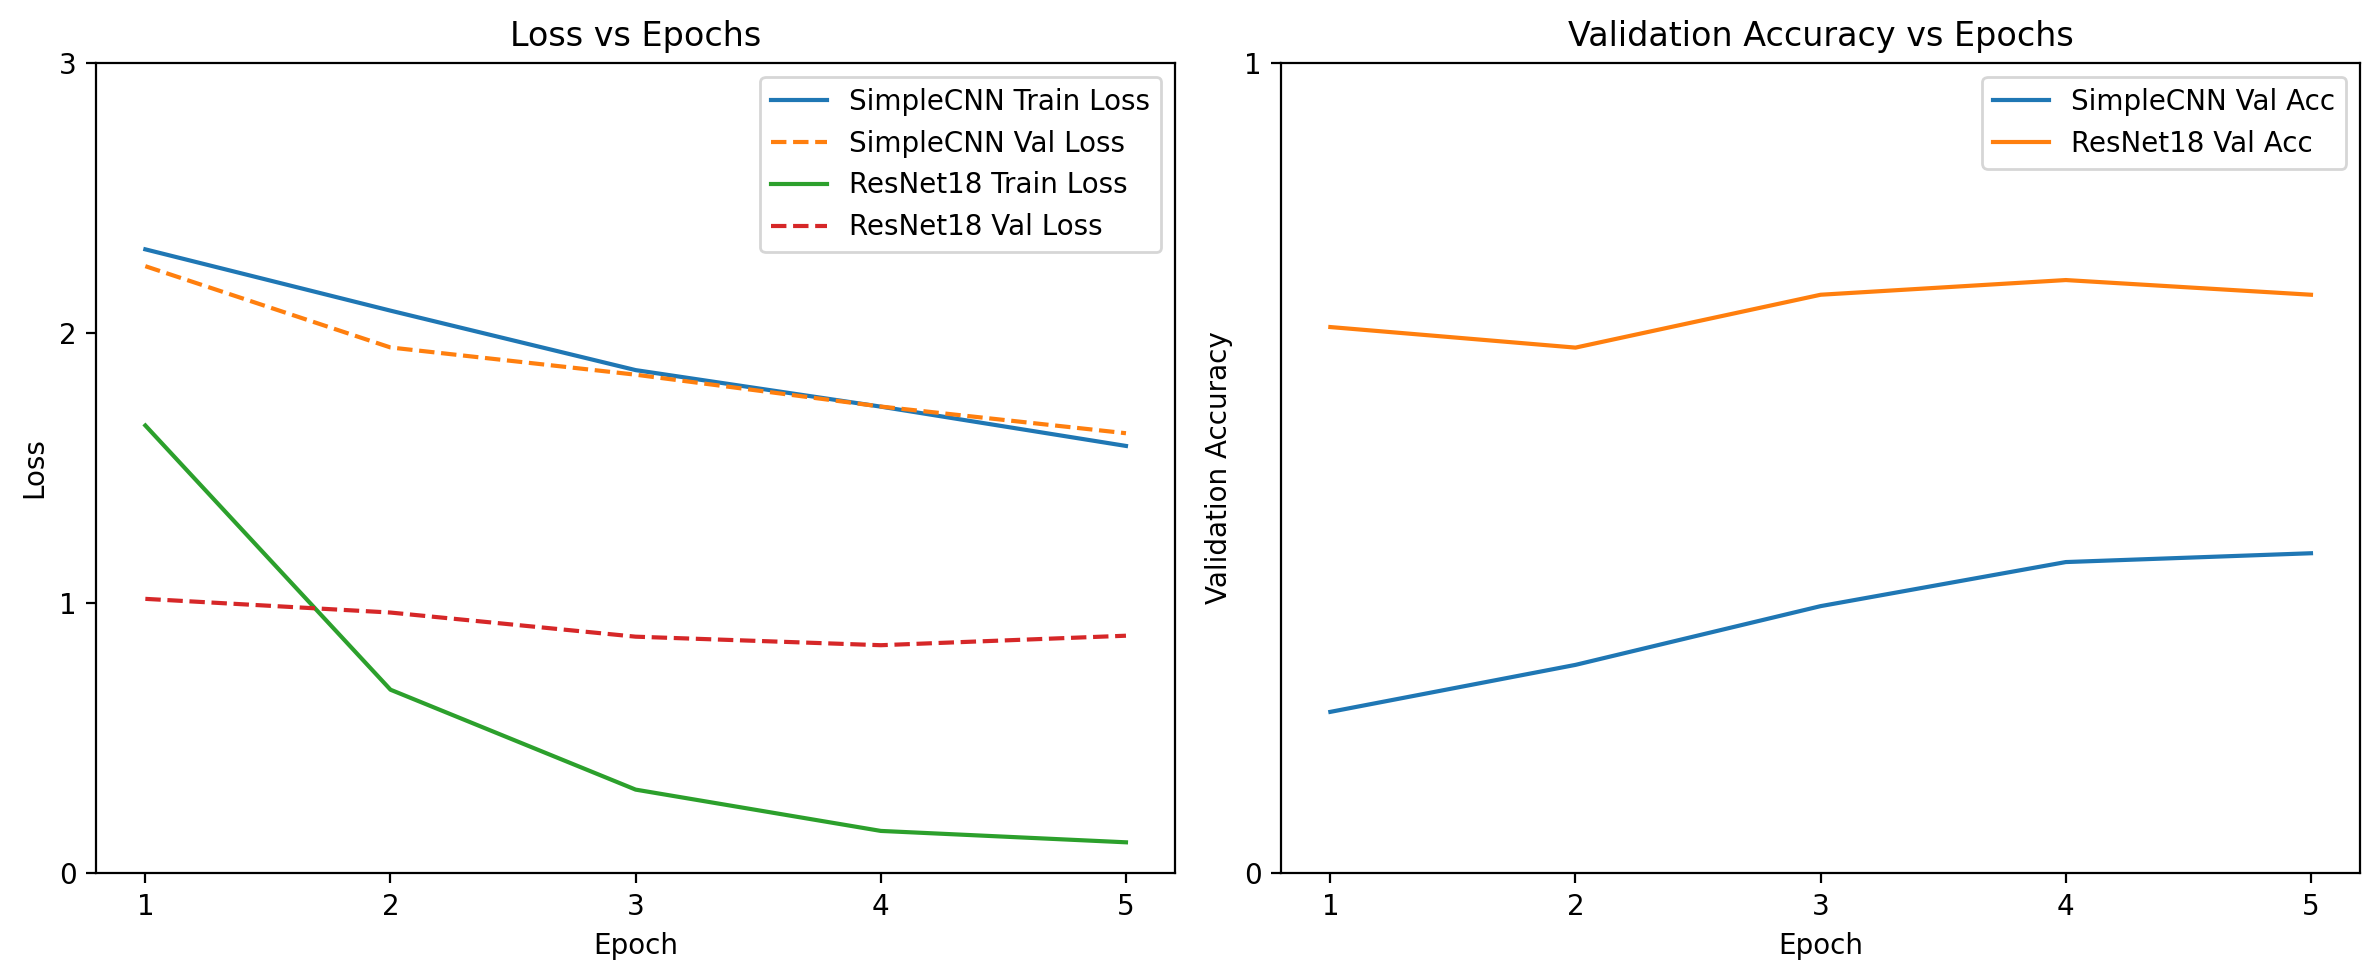

In [16]:
sys.path.append("../src")
import matplotlib.pyplot as plt
from visualization.plot_performance import plot_results

epochs = range(1, len(results['SimpleCNN']['train_loss']) + 1)
plot_results(results=results, epochs=epochs)

Confusion Matrix for SimpleCNN:


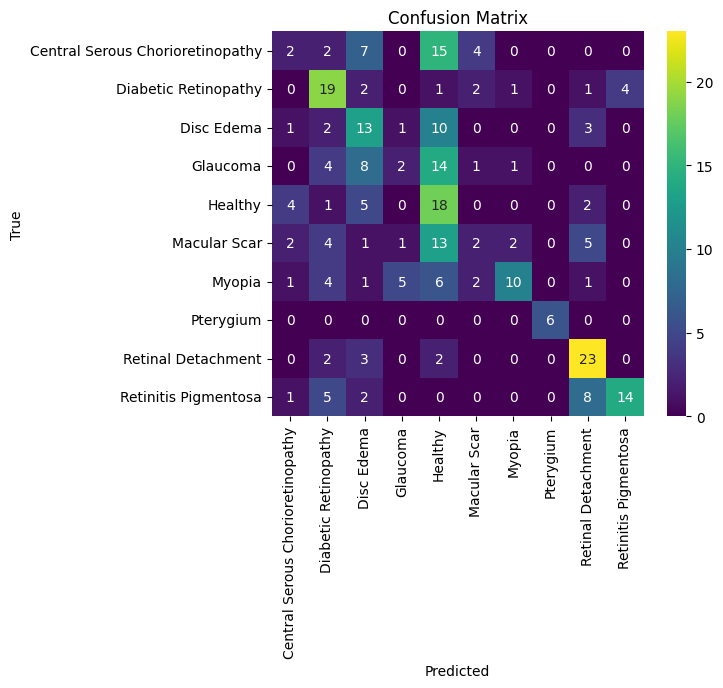

Confusion Matrix for ResNet18:


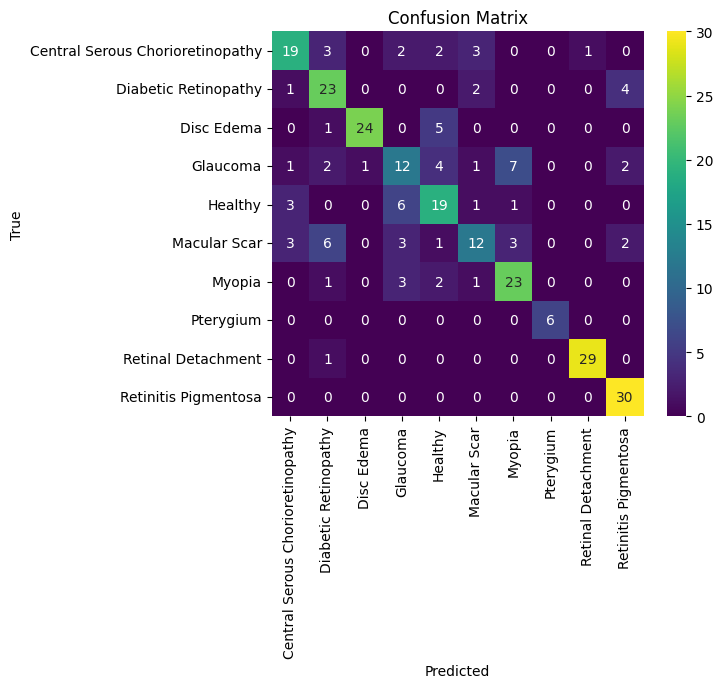

In [17]:
sys.path.append("../src")
from visualization.plot_performance import plot_confusion_matrix


# Classes and assigned index
class_names = {'Central Serous Chorioretinopathy': 0,
               'Diabetic Retinopathy': 1,
               'Disc Edema': 2,
               'Glaucoma': 3,
               'Healthy': 4,
               'Macular Scar': 5,
               'Myopia': 6,
               'Pterygium': 7,
               'Retinal Detachment': 8,
               'Retinitis Pigmentosa': 9}

# For SimpleCNN
print("Confusion Matrix for SimpleCNN:")
plot_confusion_matrix(model, val_loader, class_names.keys(), 
                      device=device, normalize=False)

# For ResNet18
print("Confusion Matrix for ResNet18:")
plot_confusion_matrix(resnet_model, val_loader, class_names.keys(), 
                      device=device, normalize=False)

In [6]:
# save model
# Save model weights
torch.save(resnet_model.state_dict(), "../models/Resnet_model_weights.pth")

In [6]:
# Load data
train_loader, val_loader = train.get_dataloaders("../data/processed/normalized_dataset_subset100.pt", 
                                                 batch_size=32)

# Create model
num_classes = len(Counter(val_loader.dataset.tensors[1].tolist())) 

# Recreate the model architecture first
saved_resnet_model = train.get_resnet18(num_classes=num_classes, pretrained=False)

# Lets load the model now and use for prediction
saved_resnet_model.load_state_dict(torch.load("../models/Resnet_model_weights.pth"))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [10]:
# Example: Use the loaded model for prediction on validation data
saved_resnet_model.to(device)
saved_resnet_model.eval()  # Set to evaluation mode

# Get a batch from the validation loader
images, labels = next(iter(val_loader))
images = images.to(device)

# Forward pass
with torch.no_grad():
    outputs = saved_resnet_model(images)
    _, preds = torch.max(outputs, 1)

# preds now contains predicted class indices for the batch
print("Predicted labels:", preds.cpu().numpy())
print("True labels:", labels.cpu().numpy())

Predicted labels: [4 1 9 0 3 2 4 0 1 6 4 2 8 3 3 9 4 0 3 2 6 6 0 4 1 4 9 5 8 0 8 5]
True labels: [6 1 9 5 3 2 3 0 1 6 2 4 8 3 5 9 2 0 4 2 3 6 0 4 1 2 9 1 8 0 8 5]


Validation Loss: 0.8830, Validation Accuracy: 0.7246


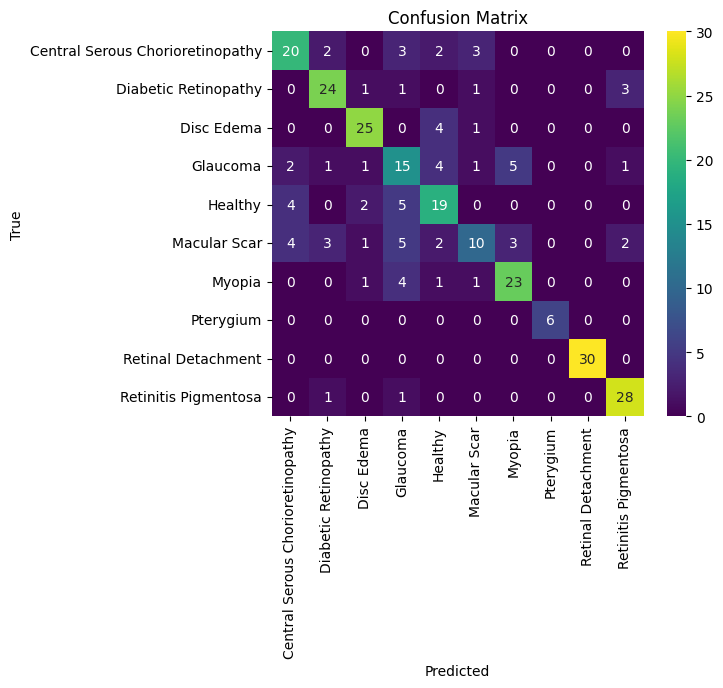

In [16]:
# Evaluate the loaded model on the validation set
avg_val_loss, val_acc = train.evaluate_model(saved_resnet_model, val_loader, device=device)
print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

plot_confusion_matrix(saved_resnet_model, val_loader, class_names, 
                      device=device, normalize=False)
plt.show()

### Lets predict a single image


In [19]:
# Predict a single image and match it with its class name

# Suppose you have a single image tensor: single_image
# Shape should be [1, C, H, W] (batch dimension included)
# Example: single_image = images[0].unsqueeze(0)  # Take first image from batch

single_image = images[0].unsqueeze(0).to(device)  # Get one image and add batch dim

saved_resnet_model.eval()
with torch.no_grad():
    output = saved_resnet_model(single_image)
    pred_idx = output.argmax(dim=1).item()  # Get predicted class index

# Map index to class name
class_names = [
    'Central Serous Chorioretinopathy',
    'Diabetic Retinopathy',
    'Disc Edema',
    'Glaucoma',
    'Healthy',
    'Macular Scar',
    'Myopia',
    'Pterygium',
    'Retinal Detachment',
    'Retinitis Pigmentosa'
]
pred_class = class_names[pred_idx]
print(f"Predicted class: {pred_class}")

Predicted class: Healthy


In [20]:
single_image

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [27]:
from PIL import Image
import torch
sys.path.append("../src")
from preprocess import preprocessing

# Path to your image
img_path = "../data/external/data/Subset100/Healthy/Healthy559.jpg"  # or .png

# Load and preprocess the image
img = Image.open(img_path).convert("RGB")
transform = preprocessing.get_transforms(img_size=(224, 224))  # Use the same size as your model
img_tensor = transform(img)  # Shape: [C, H, W]
img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Predict
# saved_resnet_model.eval()
with torch.no_grad():
    output = saved_resnet_model(img_tensor)
    pred_idx = output.argmax(dim=1).item()

# Map index to class name
class_names = [
    'Central Serous Chorioretinopathy',
    'Diabetic Retinopathy',
    'Disc Edema',
    'Glaucoma',
    'Healthy',
    'Macular Scar',
    'Myopia',
    'Pterygium',
    'Retinal Detachment',
    'Retinitis Pigmentosa'
]
pred_class = class_names[pred_idx]
print(f"Predicted class: {pred_class}")

Predicted class: Healthy
